# GloFAS Seasonal Forecast

In [3]:
import climetlab as cml
import climetlab_cems_flood as cmf
import matplotlib.pyplot as plt
import datetime
import geopandas as gpd
import pandas as pd
from climetlab_cems_flood.utils import get_po_basin

In [4]:
# pontelagoscuro
ps = (44.886111, 11.604444)

In [5]:
gdf = get_po_basin()

<AxesSubplot:>

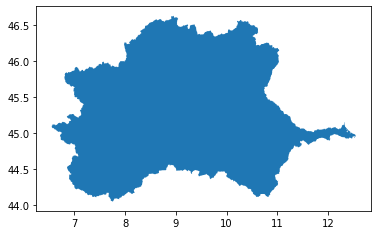

In [6]:
gdf_diss = gdf.dissolve()
gdf_diss.plot()

In [7]:
minx, miny, maxx, maxy = gdf.unary_union.bounds

In [8]:
nwse = [maxy, minx,miny, maxx] 

In [9]:
seasonal = cml.load_dataset(
            'cems-flood-glofas-seasonal',
            model='lisflood',
            system_version='operational',
            period= '20220101-20220501',#'2001-200401-04*',
            leadtime_hour = '24-3600',
            variable="river_discharge_in_the_last_24_hours",
            area= nwse,
            split_on=["month"],
            merger=None
)

By downloading data from this dataset, you agree to the terms and conditions defined at https://github.com/ecmwf-lab/climetlab_cems_flood/LICENSEIf you do not agree with such terms, do not download the data. 


  0%|          | 0/5 [00:00<?, ?it/s]

In [10]:
water_balance = cml.load_dataset(
            'cems-flood-glofas-historical',
            model='lisflood',
            product_type='intermediate',
            system_version='version_3_1',
            period= '20220101-20220525',
            variable="river_discharge_in_the_last_24_hours",
            area= nwse,
            split_on = ['hmonth'],
            threads = 6,
            merger=None
        )

By downloading data from this dataset, you agree to the terms and conditions defined at https://github.com/ecmwf-lab/climetlab_cems_flood/LICENSEIf you do not agree with such terms, do not download the data. 


  0%|          | 0/5 [00:00<?, ?it/s]

In [12]:
climatology_2000_2021 = cml.load_dataset(
            'cems-flood-glofas-historical',
            model='lisflood',
            product_type='consolidated',
            system_version='version_3_1',
            period= '2000-202101-10*',
            variable="river_discharge_in_the_last_24_hours",
            area= nwse,
            split_on = ['hyear','hmonth'],
            threads = 10,
            merger=None
        )

  0%|          | 0/220 [00:00<?, ?it/s]

In [37]:
seas = seasonal.to_xarray()
wb = water_balance.to_xarray()
cl = climatology_2000_2021.to_xarray()

In [38]:
cl = cl.chunk({"time":500})
cmean = cl.groupby("time.dayofyear").mean()
cmean = cmean.where(cmean.dayofyear != cmean.dayofyear[59], drop =True)

In [39]:
seas = seas.rio.write_crs("EPSG:4326")
cmean = cmean.rio.write_crs("EPSG:4326")
wb = wb.rio.write_crs("EPSG:4326")

In [16]:
seas = seas.rio.clip(gdf_diss.geometry)
wb = wb.rio.clip(gdf_diss.geometry)
cmean = cmean.rio.clip(gdf_diss.geometry)

In [40]:
cmean["time"] =  pd.date_range("2022-01-01","2022-10-31")

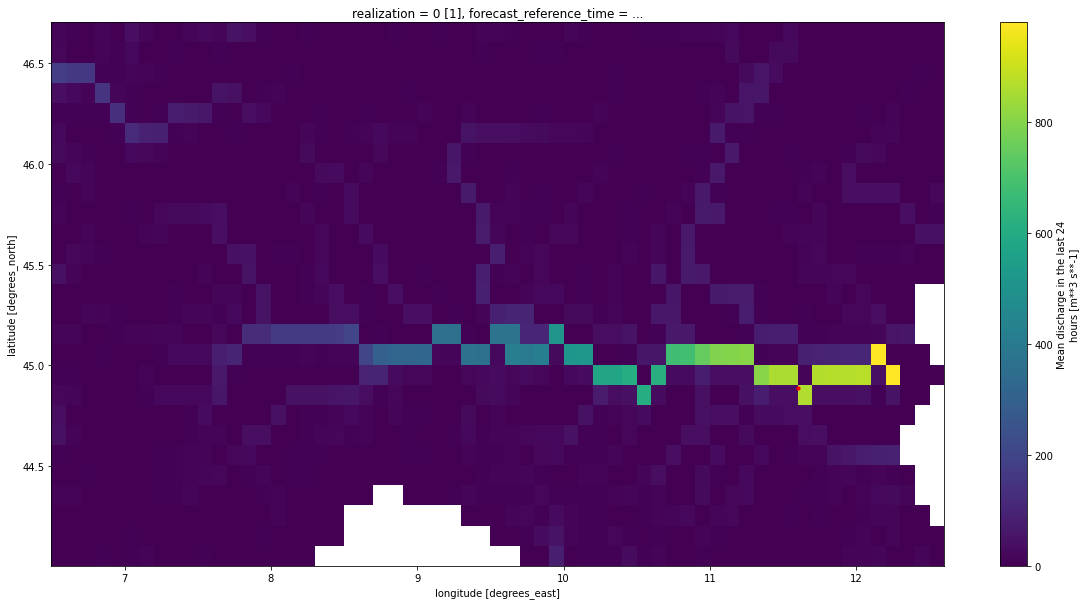

In [49]:
plt.figure(figsize=(20,10))
seas.dis24.isel(realization=0,leadtime=0,forecast_reference_time=0).plot()
plt.scatter(ps[1],ps[0],s=10,color="red")

Text(0.5, 1.0, 'Po seasonal forecasts')

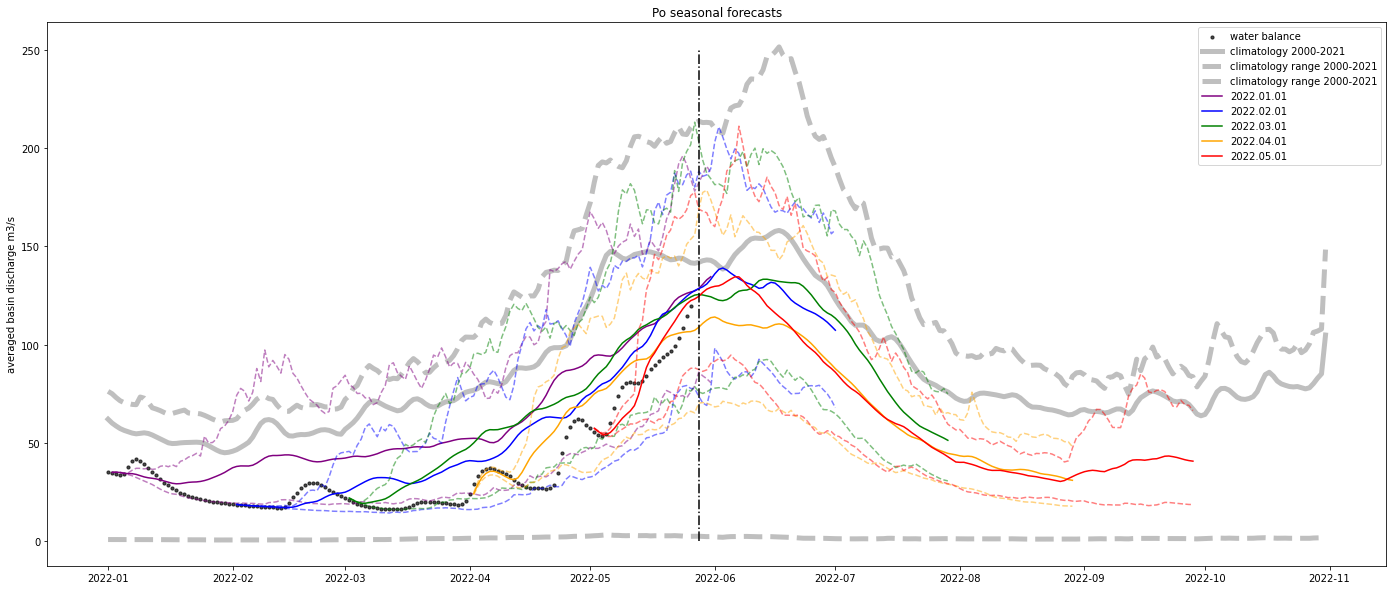

In [120]:
plt.figure(figsize=(24,10))
plt.scatter(wb.time.values,wb.dis24.mean(["latitude","longitude"]).values.T,color="black",s=10, label="water balance", alpha=0.7)
plt.plot(cmean.time.values,cmean.dis24.mean(["latitude","longitude"]).values.T, linewidth=5, color="grey",label = "climatology 2000-2021", alpha=0.5)
plt.plot(cmean.time.values,cmean.dis24.quantile((0.1,0.9),["latitude","longitude"]).values.T, linewidth=5, color="grey", linestyle="--", alpha=0.5)
for i,c in enumerate(["purple","blue","green","orange","red"]):
    t = seas.dis24.forecast_reference_time[i].values
    t = pd.to_datetime(t).strftime('%Y.%m.%d')
    d = seas.dis24.isel(forecast_reference_time=i,drop=True)
    m = d.mean(["lat","lon"])
    plt.plot(d.time.values, m.mean("realization").values.T,color=c, label=t)
    plt.plot(d.time.values, m.quantile((0.1,0.9),"realization").values.T,color=c, linestyle="--", alpha=0.5)
plt.vlines(x=datetime.datetime(2022,5,28),ymin=0,ymax=250,linestyle="-.", color="black")
plt.legend()
plt.ylabel("averaged basin discharge m3/s") 
plt.title("Po seasonal forecasts")

In [50]:
seas = seas.sel(lat=ps[0],lon=ps[1],method="nearest")

In [54]:
cmean = cmean.sel(latitude=ps[0],longitude=ps[1],method="nearest")

In [55]:
wb = wb.sel(latitude=ps[0],longitude=ps[1],method="nearest")

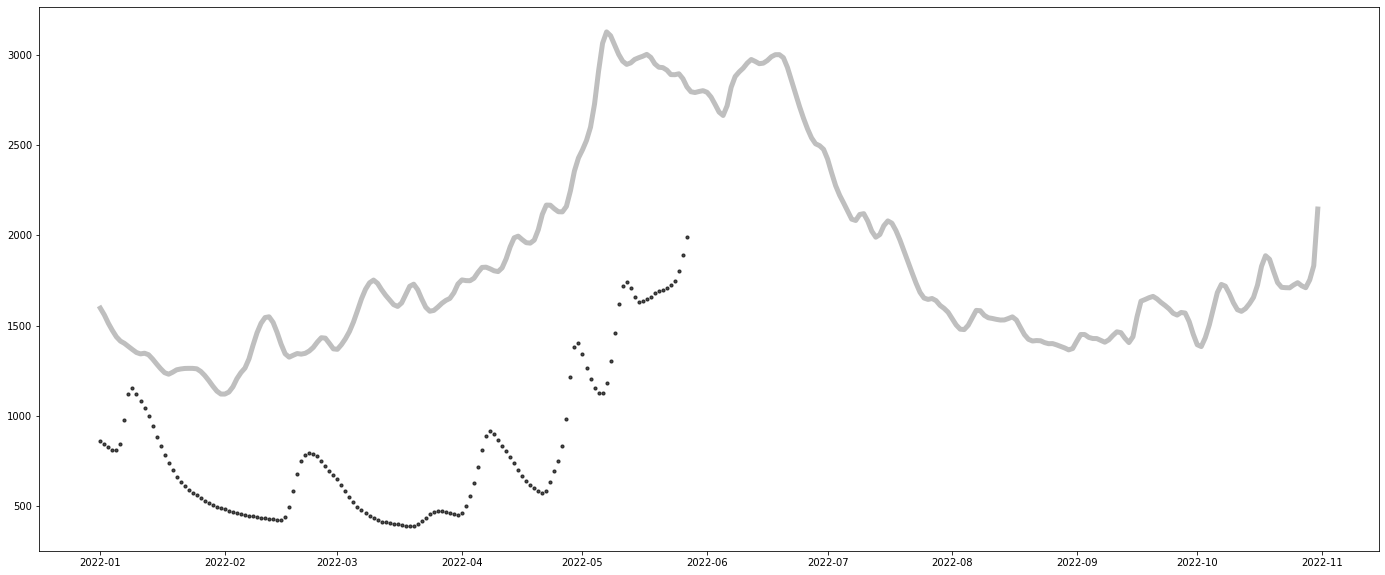

Text(0.5, 1.0, 'Po seasonal forecasts')

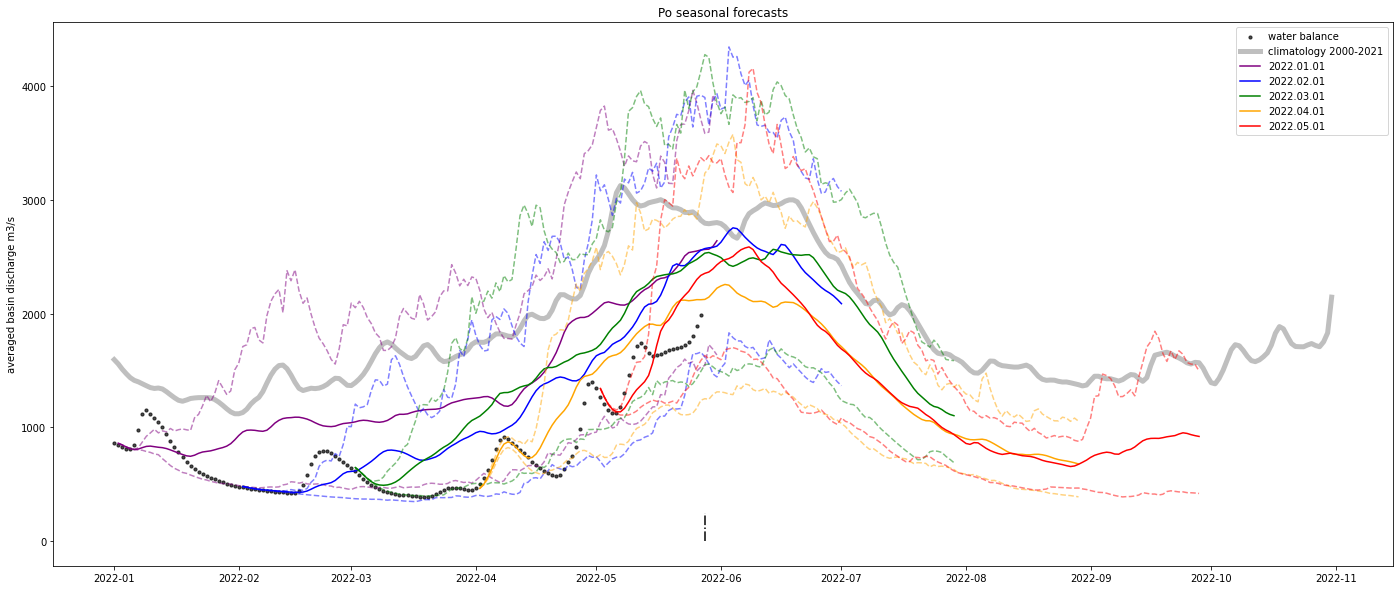

In [59]:
plt.figure(figsize=(24,10))
plt.scatter(wb.time.values,wb.dis24.values.T,color="black",s=10, label="water balance", alpha=0.7)
plt.plot(cmean.time.values,cmean.dis24.values.T, linewidth=5, color="grey",label = "climatology 2000-2021", alpha=0.5)
for i,c in enumerate(["purple","blue","green","orange","red"]):
    t = seas.dis24.forecast_reference_time[i].values
    t = pd.to_datetime(t).strftime('%Y.%m.%d')
    m = seas.dis24.isel(forecast_reference_time=i,drop=True)
    #m = d.mean(["lat","lon"])
    plt.plot(m.time.values, m.mean("realization").values.T,color=c, label=t)
    plt.plot(m.time.values, m.quantile((0.1,0.9),"realization").values.T,color=c, linestyle="--", alpha=0.5)
plt.vlines(x=datetime.datetime(2022,5,28),ymin=0,ymax=250,linestyle="-.", color="black")
plt.legend()
plt.ylabel("averaged basin discharge m3/s") 
plt.title("Po seasonal forecasts")